In [1]:
import numpy as np, cv2 as cv, matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict

# Paths / config
PROJECT_ROOT = Path.cwd()
IMG_DIR = PROJECT_ROOT / "Images" / "Test"      # adjust if needed
FILENAMES = [f"cv{i}.jpg" for i in range(1, 13)]
ALGO = "SIFT"           # or "ORB"
TARGET_W = 3000         # assignment rule (also used for K creation)
RANSAC_THRESH_E = 2.0   # px for essential-matrix RANSAC
MIN_PNP_PTS = 12
TRI_MIN_PAIR = 0        # we already cheirality-check each tri

# K from assignment rule
def build_K_from_image(img):
    h, w = img.shape[:2]
    fx = fy = float(w)
    cx, cy = w/2.0, h/2.0
    return np.array([[fx, 0, cx],
                     [0, fy, cy],
                     [0,  0,  1]], dtype=np.float64)

def write_ply(path, X, rgb=None):
    X = np.asarray(X, float)
    with open(path, "w") as f:
        f.write("ply\nformat ascii 1.0\n")
        f.write(f"element vertex {len(X)}\n")
        f.write("property float x\nproperty float y\nproperty float z\n")
        if rgb is not None:
            f.write("property uchar red\nproperty uchar green\nproperty uchar blue\n")
        f.write("end_header\n")
        for i in range(len(X)):
            if rgb is None:
                f.write(f"{X[i,0]} {X[i,1]} {X[i,2]}\n")
            else:
                r,g,b = rgb[i]
                f.write(f"{X[i,0]} {X[i,1]} {X[i,2]} {int(r)} {int(g)} {int(b)}\n")


K =
 [[3.0e+03 0.0e+00 1.5e+03]
 [0.0e+00 3.0e+03 1.5e+03]
 [0.0e+00 0.0e+00 1.0e+00]]


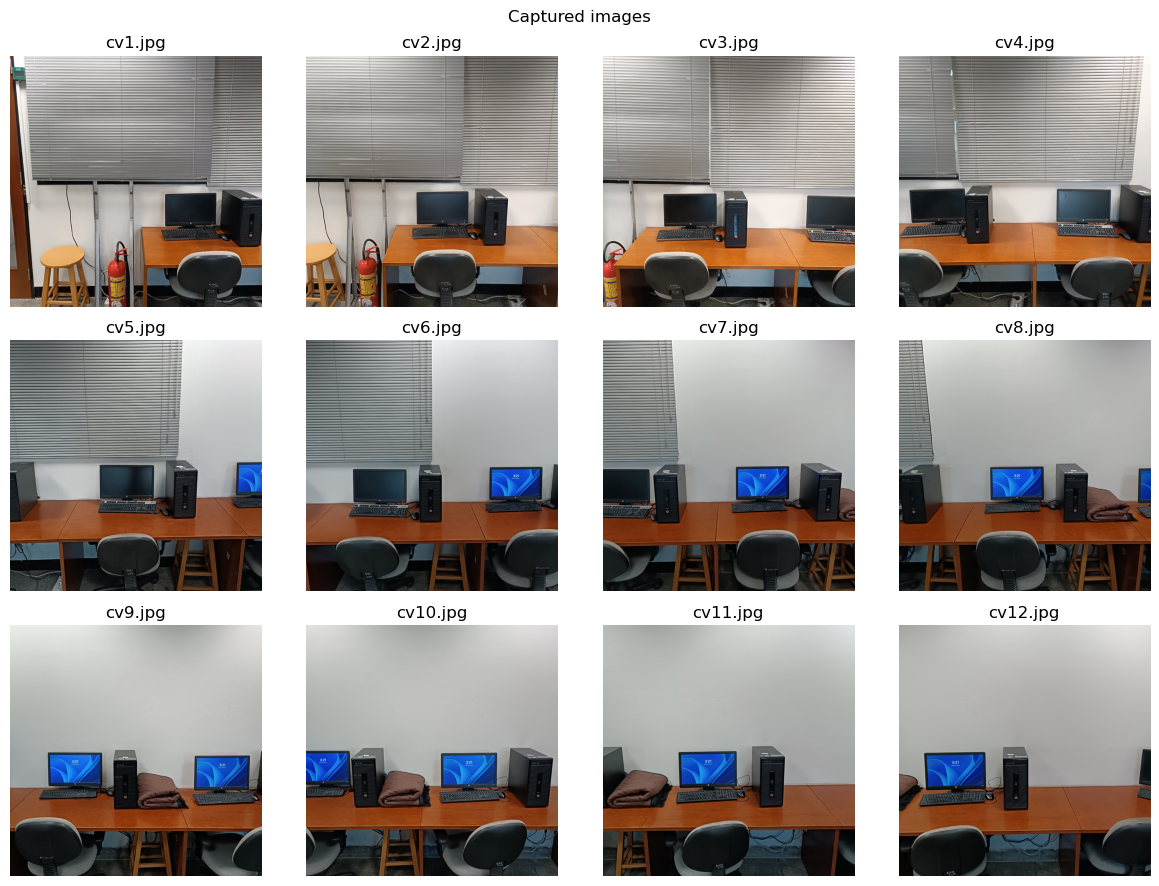

In [2]:
# Load all images, apply consistent downscale to TARGET_W if needed
imgs = []
for name in FILENAMES:
    im = cv.imread(str(IMG_DIR / name), cv.IMREAD_COLOR)
    assert im is not None, f"Missing {name}"
    if im.shape[1] > TARGET_W:
        s = TARGET_W / im.shape[1]
        im = cv.resize(im, (TARGET_W, int(im.shape[0]*s)), interpolation=cv.INTER_AREA)
    imgs.append(im)

K = build_K_from_image(imgs[0])
print("K =\n", K)

# TA: grid of 12 images
cols, rows = 4, 3
plt.figure(figsize=(12,9))
for i, im in enumerate(imgs[:12]):
    plt.subplot(rows, cols, i+1)
    plt.imshow(cv.cvtColor(im, cv.COLOR_BGR2RGB))
    plt.title(FILENAMES[i])
    plt.axis("off")
plt.suptitle("Captured images")
plt.tight_layout(); plt.show()


In [7]:
def get_detector(algo="SIFT"):
    if algo.upper() == "ORB":
        det = cv.ORB_create(nfeatures=6000)
        ratio = 0.78; norm = cv.NORM_HAMMING
    else:
        det = cv.SIFT_create(nfeatures=6000)
        ratio = 0.75; norm = cv.NORM_L2
    return det, norm, ratio

def detect_and_match(im1, im2, algo="SIFT"):
    det, norm, ratio = get_detector(algo)
    g1, g2 = cv.cvtColor(im1, cv.COLOR_BGR2GRAY), cv.cvtColor(im2, cv.COLOR_BGR2GRAY)
    kp1, des1 = det.detectAndCompute(g1, None)
    kp2, des2 = det.detectAndCompute(g2, None)
    bf = cv.BFMatcher(norm, crossCheck=False)
    knn = bf.knnMatch(des1, des2, k=2)
    good = [m for m,n in knn if n is not None and m.distance < ratio*n.distance]
    pts1 = np.float32([kp1[m.queryIdx].pt for m in good])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in good])
    return kp1, kp2, good, pts1, pts2

def draw_matches_inline(im1, kp1, im2, kp2, matches, title="", scale=0.35):
    vis = cv.drawMatches(im1, kp1, im2, kp2, matches, None,
                         flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    h,w = vis.shape[:2]
    vis = cv.resize(vis, (int(w*scale), int(h*scale)))
    plt.figure(figsize=(12,6)); plt.imshow(cv.cvtColor(vis, cv.COLOR_BGR2RGB))
    plt.title(title); plt.axis("off"); plt.show()

def find_E_ransac(pts1, pts2, K, threshold_px=2.0):
    E, mask = cv.findEssentialMat(pts1, pts2, K, method=cv.RANSAC,
                                  prob=0.999, threshold=threshold_px)
    if mask is None:
        return None, None, None, None
    in1 = pts1[mask.ravel()==1]
    in2 = pts2[mask.ravel()==1]
    keep = mask.ravel()==1
    return E, in1, in2, keep

def select_pose_by_cheirality(E, K, in1, in2):
    # Try the 4 possible [R|t], pick the one with max positive depth in both views
    P1 = K @ np.hstack([np.eye(3), np.zeros((3,1))])
    best = (-1, None, None, None, None)  # (count, R, t, X_all, mask)
    for _ in range(1):  # recoverPose already disambiguates; still returning for consistency
        _, R, t, mask = cv.recoverPose(E, in1, in2, K)
        P2 = K @ np.hstack([R, t])
        Xh = cv.triangulatePoints(P1, P2, in1.T, in2.T)
        X  = (Xh[:3] / Xh[3]).T
        # Cheirality: in front of cam1 and cam2
        z1 = X[:,2]
        z2 = (R[2].dot(X.T) + t[2,0]).ravel()
        keep = (z1 > 0) & (z2 > 0)
        cnt = int(np.count_nonzero(keep))
        if cnt > best[0]:
            best = (cnt, R, t, X, keep)
    return best  # count, R, t, X_all, mask_cheir


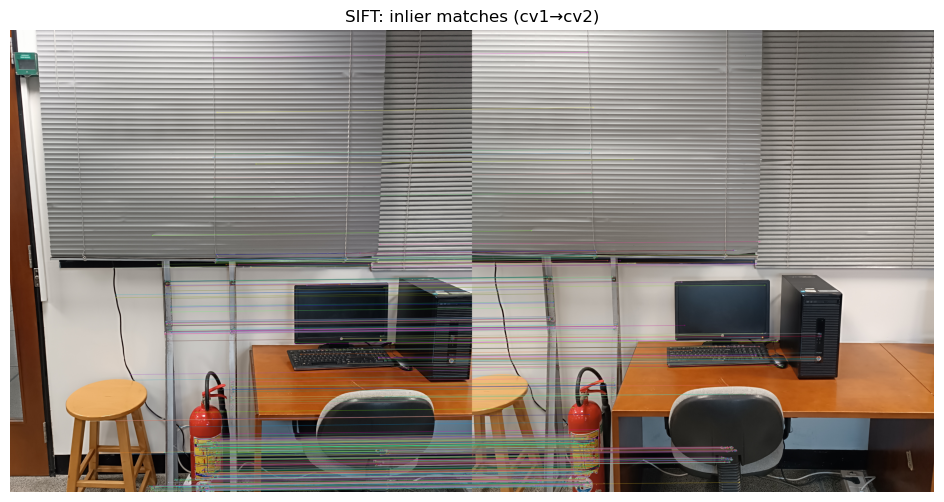

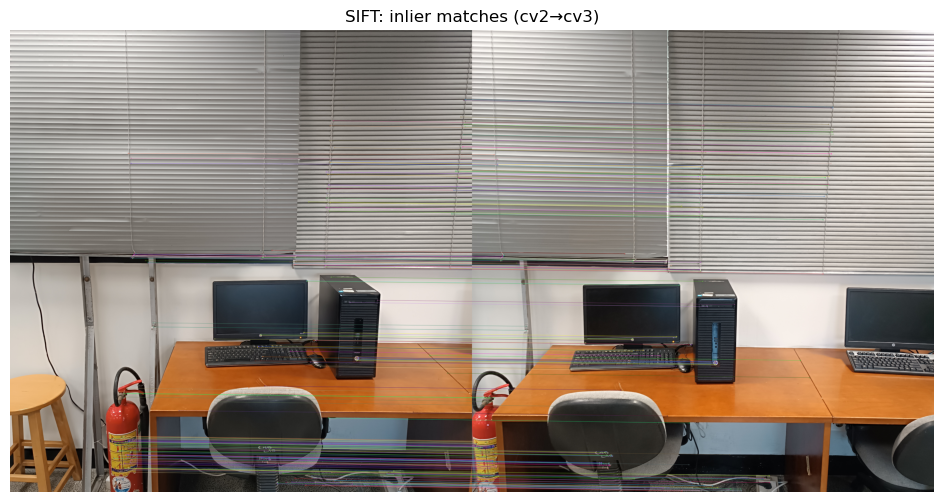

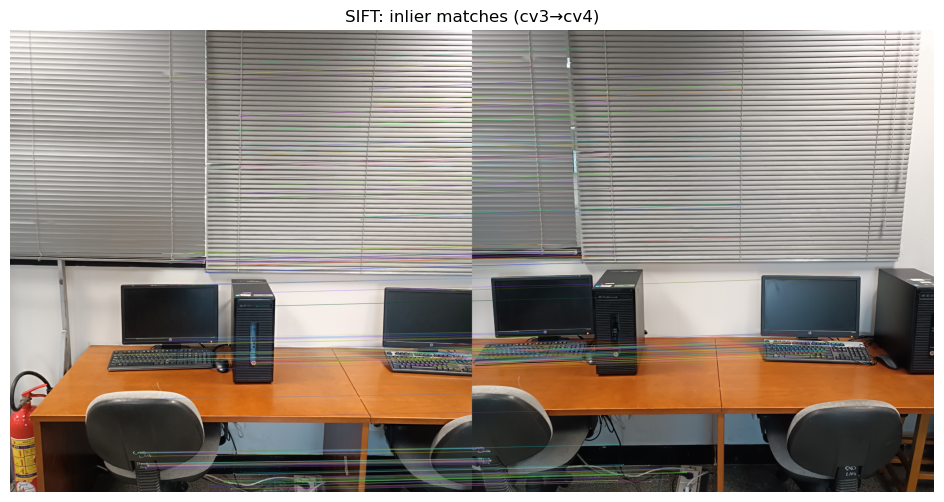

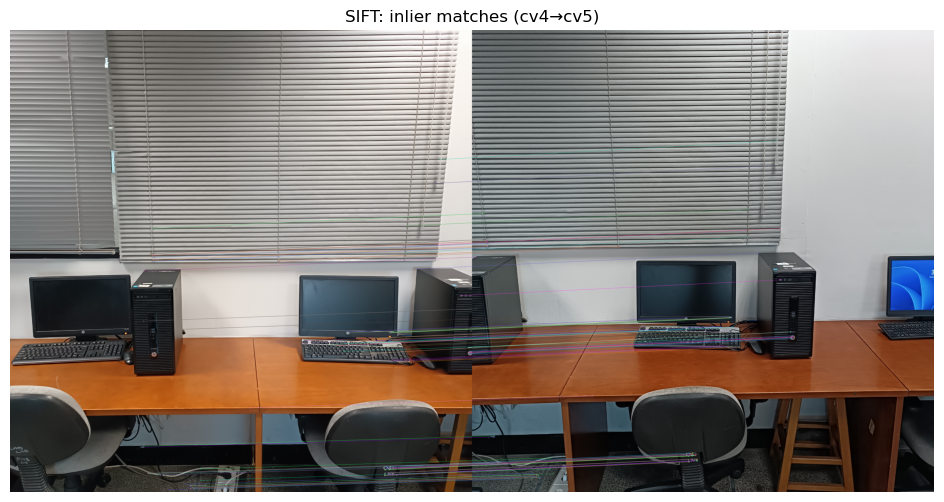

In [8]:
pairs = [(1,2),(2,3),(3,4),(4,5)]  # 1-based for readability
for i,j in pairs:
    im1, im2 = imgs[i-1], imgs[j-1]
    kp1, kp2, good, pts1, pts2 = detect_and_match(im1, im2, algo=ALGO)
    E, in1, in2, keep = find_E_ransac(pts1, pts2, K, threshold_px=RANSAC_THRESH_E)
    inlier_matches = [m for m,k in zip(good, keep) if k]
    draw_matches_inline(im1, kp1, im2, kp2, inlier_matches,
                        title=f"{ALGO}: inlier matches (cv{i}→cv{j})", scale=0.5)


In [9]:
# Bootstrap from (cv1, cv2)
im1, im2 = imgs[0], imgs[1]
kp1, kp2, good, pts1_all, pts2_all = detect_and_match(im1, im2, algo=ALGO)
E, in1_E, in2_E, keep_E = find_E_ransac(pts1_all, pts2_all, K, threshold_px=RANSAC_THRESH_E)
cnt, R2, t2, X12_all, mask12 = select_pose_by_cheirality(E, K, in1_E, in2_E)

in1 = in1_E[mask12]; in2 = in2_E[mask12]
X12 = X12_all[mask12]

# Map state
cams_seq = {0: (np.eye(3), np.zeros((3,1))), 1: (R2, t2)}
points_3d = list(map(np.array, X12))
pid_of = [dict() for _ in imgs]   # kp_index -> pid
# nearest-kp assign
pts_kp1 = np.float32([k.pt for k in kp1])
pts_kp2 = np.float32([k.pt for k in kp2])
for pt1, pt2, X in zip(in1, in2, X12):
    i1 = int(np.argmin(np.linalg.norm(pts_kp1 - pt1, axis=1)))
    i2 = int(np.argmin(np.linalg.norm(pts_kp2 - pt2, axis=1)))
    pid = len(points_3d) - len(X12) + np.where((X12==X).all(axis=1))[0][0]  # stable id
    pid_of[0][i1] = pid
    pid_of[1][i2] = pid

print(f"Bootstrapped: inliers={len(X12)} | map points={len(points_3d)}")


Bootstrapped: inliers=604 | map points=604


In [10]:
# ----- replace the "for k in range(2, len(imgs)):" body in Cell 6 with THIS -----
ANCHOR_BACK = 3          # look back up to 3 posed cameras
MIN_PNP_PTS = 10         # slightly lower threshold helps keep going

for k in range(2, len(imgs)):
    # 1) Collect 3D-2D correspondences for PnP from multiple recent anchors
    obj3d = []
    img2d = []
    idx_cur = []
    pid_seen = set()

    # list recent anchors that already have poses
    anchors = [a for a in range(max(0, k-ANCHOR_BACK), k) if a in cams_seq]
    anchors.sort(reverse=True)  # start from closest (k-1), then k-2, ...
    bf = cv.BFMatcher(norm, crossCheck=False)

    for a in anchors:
        # match descriptors between anchor 'a' and current 'k'
        knn = bf.knnMatch(descs[a], descs[k], k=2)
        good = [m for m,n in knn if n is not None and m.distance < ratio*n.distance]
        # for matches whose anchor-kp has a mapped pid, use it
        for m in good:
            q = m.queryIdx   # kp index in anchor a
            t = m.trainIdx   # kp index in current k
            if q in pid_of[a]:
                pid = pid_of[a][q]
                if pid in pid_seen:    # avoid duplicate pids from multiple anchors
                    continue
                pid_seen.add(pid)
                obj3d.append(points_3d[pid])
                img2d.append(kps[k][t].pt)
                idx_cur.append(t)

    obj3d = np.asarray(obj3d, dtype=np.float64)
    img2d = np.asarray(img2d, dtype=np.float64)

    if len(obj3d) < MIN_PNP_PTS:
        print(f"[cam{k+1}] Not enough 3D-2D for PnP ({len(obj3d)}).")
        continue

    # 2) Robust PnP + refinement
    ok, rvec, tvec, inliers = cv.solvePnPRansac(
        objectPoints=obj3d,
        imagePoints=img2d,
        cameraMatrix=K,
        distCoeffs=None,
        iterationsCount=3000,       # a bit more effort
        reprojectionError=3.0,      # slightly looser gate
        confidence=0.999,
        flags=cv.SOLVEPNP_EPNP      # stable initializer
    )
    if not ok or inliers is None or len(inliers) < 6:
        print(f"[cam{k+1}] PnP failed/inliers too few.")
        continue

    # local non-linear refinement (Levenberg-Marquardt)
    try:
        rvec, tvec = cv.solvePnPRefineLM(
            objectPoints=obj3d[inliers.ravel()],
            imagePoints=img2d[inliers.ravel()],
            cameraMatrix=K, distCoeffs=None,
            rvec=rvec, tvec=tvec
        )
    except Exception:
        pass  # older OpenCV may not have refineLM

    Rk, _ = cv.Rodrigues(rvec); tk = tvec.reshape(3,1)
    cams_seq[k] = (Rk, tk)
    print(f"[cam{k+1}] pose inliers={len(inliers)} (anchors used: {len(anchors)})")

    # 3) Connect PnP inlier observations to pid_of[k] so future frames can reuse them
    for ii in inliers.ravel().tolist():
        # We only have idx_cur (kp index in k). Need pid: recompute which anchor provided it.
        # Simple heuristic: project back to anchors to find the closest match source.
        t_idx = idx_cur[ii]
        # Try anchors in order; first one that has a match to this kp becomes the source
        assigned = False
        for a in anchors:
            # nearest neighbor in descriptor space to get original 'q' (cheap approximation)
            knn = bf.knnMatch(descs[a], descs[k][t_idx:t_idx+1], k=1)
            if not knn or not knn[0]: 
                continue
            q = knn[0][0].queryIdx
            if q in pid_of[a]:
                pid_of[k][t_idx] = pid_of[a][q]
                assigned = True
                break
        # if not assigned, skip (it only affects reuse later)

    # 4) Triangulate NEW points just with previous frame (k-1) as before (simple & fast)
    if (k-1) in cams_seq:
        R_prev, t_prev = cams_seq[k-1]
        P1 = K @ np.hstack([R_prev, t_prev])
        P2 = K @ np.hstack([Rk, tk])

        # match (k-1,k) again for candidate new correspondences
        knn = bf.knnMatch(descs[k-1], descs[k], k=2)
        good_prev = [m for m,n in knn if n is not None and m.distance < ratio*n.distance]
        new_tri = 0
        for m in good_prev:
            qi, ti = m.queryIdx, m.trainIdx
            if (qi in pid_of[k-1]) or (ti in pid_of[k]):   # already mapped
                continue
            pt_prev = np.float64(kps[k-1][qi].pt).reshape(2,1)
            pt_cur  = np.float64(kps[k][ti].pt).reshape(2,1)
            Xh = cv.triangulatePoints(P1, P2, pt_prev, pt_cur)
            X  = (Xh[:3] / Xh[3]).ravel()
            if X[2] <= 0:
                continue
            Xk = Rk @ X.reshape(3,1) + tk
            if Xk[2,0] <= 0:
                continue
            pid = len(points_3d)
            points_3d.append(X)
            pid_of[k-1][qi] = pid
            pid_of[k][ti]   = pid
            new_tri += 1
        print(f"[cam{k+1}] triangulated new points: {new_tri}")

X_seq = np.asarray(points_3d, float)
print(f"\nSequential SfM done: cams={len(cams_seq)} / points={len(X_seq)}")


[cam3] pose inliers=45 (anchors used: 2)
[cam3] triangulated new points: 215
[cam4] pose inliers=12 (anchors used: 3)
[cam4] triangulated new points: 195
[cam5] PnP failed/inliers too few.
[cam6] pose inliers=7 (anchors used: 2)
[cam7] PnP failed/inliers too few.
[cam8] Not enough 3D-2D for PnP (0).
[cam9] Not enough 3D-2D for PnP (0).
[cam10] Not enough 3D-2D for PnP (0).
[cam11] Not enough 3D-2D for PnP (0).
[cam12] Not enough 3D-2D for PnP (0).

Sequential SfM done: cams=5 / points=1014


In [11]:
from scipy.sparse import lil_matrix
from scipy.optimize import least_squares

# Build observation list: (cam_id, pid, x,y)
obs = []
for i in range(len(imgs)):
    R,t = cams_seq.get(i, (None,None))
    if R is None: continue
    for kp_idx, pid in pid_of[i].items():
        x,y = kps[i][kp_idx].pt
        obs.append((i, pid, x, y))
obs = np.array(obs, dtype=float)
print(f"BA set: cams={len(cams_seq)}, points={len(X_seq)}, observations={len(obs)}")

# Param vector: cams (rvec(3)+t(3)) then points (3)
cam_index = {i:c for c,i in enumerate(sorted(cams_seq.keys()))}
C = len(cam_index); P = len(X_seq)
def pack_params(cams, X):
    theta = []
    for i in sorted(cam_index, key=lambda x: cam_index[x]):
        R,t = cams[i]
        rvec,_ = cv.Rodrigues(R)
        theta.extend(rvec.ravel()); theta.extend(t.ravel())
    theta.extend(X.ravel())
    return np.array(theta, float)

def unpack_params(theta):
    cams = {}
    off = 0
    for i in sorted(cam_index, key=lambda x: cam_index[x]):
        rvec = theta[off:off+3]; t = theta[off+3:off+6]; off += 6
        R,_ = cv.Rodrigues(rvec.reshape(3,1))
        cams[i] = (R, t.reshape(3,1))
    X = theta[off:].reshape(-1,3)
    return cams, X

def project(R,t,X3):
    Xc = (R @ X3.T + t).T
    u = (K[0,0]*Xc[:,0]/Xc[:,2]) + K[0,2]
    v = (K[1,1]*Xc[:,1]/Xc[:,2]) + K[1,2]
    return np.stack([u,v], axis=1)

def residuals(theta):
    cams, X = unpack_params(theta)
    res = np.empty(2*len(obs), float)
    for k,(ci,pid,u,v) in enumerate(obs):
        ci = int(ci); pid = int(pid)
        if ci not in cams: res[2*k:2*k+2] = 0; continue
        R,t = cams[ci]
        uv = project(R,t,X[pid:pid+1])[0]
        res[2*k:2*k+2] = uv - np.array([u,v])
    return res

theta0 = pack_params(cams_seq, X_seq)
res = least_squares(residuals, theta0, method="lm", max_nfev=120, xtol=1e-12, ftol=1e-12)
cams_seq, X_seq = unpack_params(res.x)
print("Fast BA done. cams_seq and X_seq updated.")


IndexError: tuple index out of range